In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt
import random

import tensorflow as tf


In [2]:
seed = 42

os.listdir('/kaggle/input/')

['model-weights', 'cassava-leaf-disease-classification']

In [3]:
images_df = pd.read_csv('/kaggle/input/cassava-leaf-disease-classification/train.csv')#, dtype = str)
images_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [4]:
images_df = images_df.sample(frac = 1, random_state = seed)
images_df.head()

,image_id,label
9134,2615227158.jpg,4
1580,1277648239.jpg,3
7304,2305895487.jpg,3
13196,336299725.jpg,2
5333,1951270318.jpg,2


In [5]:
train_folder = '/kaggle/input/cassava-leaf-disease-classification/train_images/'
images_df['image path'] = train_folder + images_df['image_id']
images_df.head()

,image_id,label,image path
9134,2615227158.jpg,4,/kaggle/input/cassava-leaf-disease-classificat...
1580,1277648239.jpg,3,/kaggle/input/cassava-leaf-disease-classificat...
7304,2305895487.jpg,3,/kaggle/input/cassava-leaf-disease-classificat...
13196,336299725.jpg,2,/kaggle/input/cassava-leaf-disease-classificat...
5333,1951270318.jpg,2,/kaggle/input/cassava-leaf-disease-classificat...


In [6]:
print(len(images_df))

21397


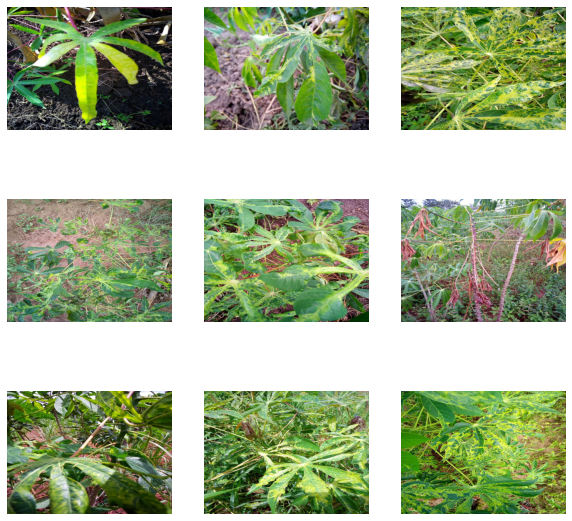

In [7]:
plt.figure(figsize=(10, 10))
for i, image_path in enumerate(images_df.sample(9)['image path']):
    ax = plt.subplot(3, 3, i + 1)
    image = Image.open(image_path)
    plt.imshow(image)
    #plt.title(int(label))
    plt.axis("off")


In [8]:
train_val_split = 0.9
train_count = int(len(images_df) * train_val_split)
val_count = int(len(images_df) * (1 - train_val_split))
print(f'Number of training samples {train_count}')
print(f'Number of validation samples {val_count}')

Number of training samples 19257
Number of validation samples 2139


In [9]:
train_images_df = images_df[:train_count]
val_images_df = images_df[train_count:]

In [10]:
batch_size = 8
image_size = 600
input_shape = (image_size, image_size, 3)
dropout_rate = 0.5
classes_to_predict = np.sort(train_images_df['label'].unique())
print(classes_to_predict)

[0 1 2 3 4]


In [11]:
#train_images_df.label.astype(int)
print(train_images_df.dtypes)

image_id      object
label          int64
image path    object
dtype: object


#Data augmentation with ImageDataGenerator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                              rotation_range = 40,
                                                              width_shift_range = 0.2,
                                                              height_shift_range = 0.2,
                                                              brightness_range = (0.6, 1.2),  
                                                              shear_range = 0.2,
                                                              zoom_range = 0.2,
                                                              horizontal_flip = True,
                                                              fill_mode = 'nearest')
train_generator = train_datagen.flow_from_dataframe(train_images_df,
                                                   directory = train_folder,
                                                   x_col = 'image_id',
                                                   y_col = 'label',
                                                   target_size = (image_size, image_size),
                                                   color_mode = 'rgb',
                                                   class_mode = 'sparse',
                                                   batch_size = batch_size)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
val_generator = val_datagen.flow_from_dataframe(val_images_df,
                                               directory = train_folder,
                                               x_col = 'image_id',
                                               y_col = 'label',
                                               target_size = (image_size, image_size),
                                               color_mode = 'rgb',
                                               class_mode = 'sparse',
                                               batch_size = batch_size)

In [12]:
train_data = tf.data.Dataset.from_tensor_slices((train_images_df['image path'].values, train_images_df['label'].values))
val_data = tf.data.Dataset.from_tensor_slices((val_images_df['image path'].values, val_images_df['label'].values))

In [13]:
autotune = tf.data.AUTOTUNE
print(autotune)

-1


In [14]:
def load_image_and_label_from_path(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels = 3)
    return image, label

train_data = train_data.map(load_image_and_label_from_path, num_parallel_calls = autotune)
val_data = val_data.map(load_image_and_label_from_path, num_parallel_calls = autotune)

In [15]:
train_data_batches = train_data.shuffle(buffer_size = 1000).batch(batch_size = batch_size).prefetch(buffer_size = autotune)
val_data_batches = val_data.batch(batch_size = batch_size).prefetch(buffer_size = autotune)

In [16]:
print(val_images_df.label.values)

[3 1 3 ... 2 3 1]


In [ ]:
print(train_data_batches)

In [ ]:
def load_image_and_label_from_path_for_adapt(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels = 3)
    image = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(image)
    #image = tf.keras.layers.experimental.preprocessing.RandomCrop(height = image_size, width = image_size)(image)
    image = tf.keras.layers.experimental.preprocessing.Resizing(image_size, image_size)(image)
    return image

adapt_data = tf.data.Dataset.from_tensor_slices(train_images_df['image path'].values)
adapt_data = adapt_data.map(load_image_and_label_from_path_for_adapt, num_parallel_calls = autotune)
adapt_data_batches = adapt_data.batch(batch_size = batch_size).prefetch(buffer_size = autotune)

In [17]:
augment_layers = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomCrop(height = image_size, width = image_size),
    tf.keras.layers.experimental.preprocessing.RandomFlip(),
    tf.keras.layers.experimental.preprocessing.RandomZoom((-0.2, 0.3)),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.3),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3)
])

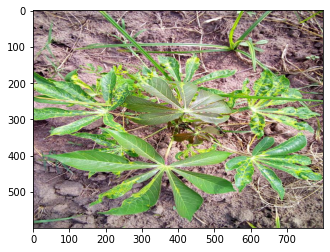

(800, 600)

In [18]:
preview = Image.open(images_df.iloc[1]['image path'])
plt.imshow(preview)
plt.show()
preview.size

(1, 600, 800, 3)
(1, 600, 600, 3)


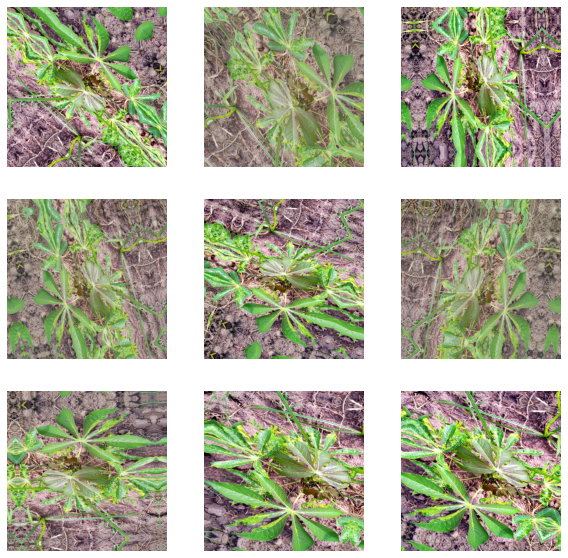

In [19]:
plt.figure(figsize=(10, 10))
image = tf.expand_dims(np.array(preview), 0)
print(image.shape)
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = augment_layers(image)
    plt.imshow(augmented_image[0])
    #plt.title(int(label))
    plt.axis("off")
print(augmented_image.shape)    

In [20]:
from tensorflow.keras.applications import EfficientNetB3
model = EfficientNetB3(weights = 'imagenet',
                       include_top = False,
                       drop_connect_rate = 0.5)
                       #input_shape = input_shape)

43941888/43941136 [==============================] - 0s 0us/step


In [ ]:
model.summary()

In [ ]:
model.trainable = False

In [21]:
def build_model(base_model):
    inputs = tf.keras.layers.Input(shape = input_shape)
    x = augment_layers(inputs)
    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(len(classes_to_predict), activation = 'softmax')(x)
    
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    
    return model

In [22]:
final_model = build_model(model)

In [23]:
final_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 600, 600, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 600, 600, 3)       0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, None, None, 1536)  10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 7685      
Total params: 10,791,220
Trainable params: 10,703,917
Non-trainable params: 87,303
____________________________________________

In [26]:
from sklearn.utils.class_weight import compute_class_weight

class_weight = compute_class_weight('balanced',
                                   classes = classes_to_predict,
                                   y = train_images_df.label.values)
print(class_weight)

[3.98283351 1.94810319 1.78553547 0.32509496 1.6679948 ]


In [40]:
epochs = 2
callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                             patience = 3),
             tf.keras.callbacks.ModelCheckpoint(filepath = 'best_model.h5',
                                                monitor='val_loss', 
                                                save_best_only=True,
                                                save_weights_only = True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.3,
                                                 patience=2,
                                                 mode = 'min')]
optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-5)
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()

class_weights = {0 : 4,
                1 : 2,
                2 : 2,
                3 : 0.5,
                4 : 2}

final_model.compile(loss = loss_function,
                   optimizer = optimizer,
                   metrics = ['acc'])

In [41]:
hist = final_model.fit(train_data_batches,
                      epochs = epochs,
                      validation_data = val_data_batches,
                      callbacks = callbacks,
                      class_weight = class_weights)

Epoch 1/2
2408/2408 [==============================] - 2106s 866ms/step - loss: 0.6499 - acc: 0.8585 - val_loss: 0.4332 - val_acc: 0.8748
Epoch 2/2
2408/2408 [==============================] - 2050s 850ms/step - loss: 0.6274 - acc: 0.8611 - val_loss: 0.4144 - val_acc: 0.8631


In [ ]:
final_model.save_weights('Checkpoint_val_loss_0p361.h5') 

In [28]:
final_model.load_weights("../input/model-weights/Checkpoint_val_loss_0p361.h5")

In [29]:
eval_before = final_model.evaluate(val_data_batches)

268/268 [==============================] - 52s 156ms/step - loss: 0.3631 - acc: 0.8919


In [ ]:
eval_after = final_model.evaluate(val_data_batches)

In [ ]:
%%time
final_model.get_layer('efficientnetb3').get_layer('normalization').adapt(adapt_data_batches)

In [ ]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

   
    


unfreeze_model(final_model)

In [ ]:
! ls

In [ ]:
! pwd

In [ ]:
from IPython.display import FileLink
FileLink('Checkpoint_val_loss_0p36.h5')

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [ ]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [42]:
val_predict = final_model.predict(val_data_batches)

In [31]:
print(val_predict)

[[2.1025007e-06 4.9330328e-07 3.8841201e-05 9.9946588e-01 4.9262540e-04]
 [9.9738147e-03 3.4723870e-02 5.6179003e-03 9.3813616e-01 1.1548298e-02]
 [5.0537881e-08 2.0003852e-09 5.5259047e-04 9.9944526e-01 2.1355438e-06]
 ...
 [1.9108170e-03 1.8964550e-02 9.3546057e-01 1.5446622e-02 2.8217452e-02]
 [5.4517845e-06 1.1410888e-06 2.5668967e-06 9.9997640e-01 1.4382578e-05]
 [3.0792857e-05 9.9913508e-01 2.4654239e-05 7.6113868e-04 4.8341375e-05]]


In [43]:
val_y = np.argmax(val_predict, axis=1)

In [33]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(val_images_df.label.values, val_y))

[[  85   11    1    4   19]
 [  12  173    7    7   13]
 [   1    6  197   15   10]
 [   1    7   26 1268    9]
 [  29   15   22   20  182]]


In [34]:
print(classification_report(val_images_df.label.values, val_y))

              precision    recall  f1-score   support

           0       0.66      0.71      0.69       120
           1       0.82      0.82      0.82       212
           2       0.78      0.86      0.82       229
           3       0.96      0.97      0.97      1311
           4       0.78      0.68      0.73       268

    accuracy                           0.89      2140
   macro avg       0.80      0.81      0.80      2140
weighted avg       0.89      0.89      0.89      2140



In [44]:
print(confusion_matrix(val_images_df.label.values, val_y))

[[  93    8    0    1   18]
 [  17  173    5    4   13]
 [   4    4  201   10   10]
 [  11   29   56 1200   15]
 [  35   14   24   15  180]]


In [45]:
print(classification_report(val_images_df.label.values, val_y))

              precision    recall  f1-score   support

           0       0.58      0.78      0.66       120
           1       0.76      0.82      0.79       212
           2       0.70      0.88      0.78       229
           3       0.98      0.92      0.94      1311
           4       0.76      0.67      0.71       268

    accuracy                           0.86      2140
   macro avg       0.76      0.81      0.78      2140
weighted avg       0.88      0.86      0.87      2140

